In [1]:
import tensorflow as tf
from tensorflow.keras.models import load_model


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "C:\Users\Habib\anaconda3\Lib\runpy.py", line 198, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\Habib\anaconda3\Lib\runpy.py", line 88, in _run_code
    exec(code, run_globals)
  File "C:\Users\Habib\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\Users\Habib\anaconda3\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "C:\Users\Habib\anaconda3\Lib\site-pac

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "C:\Users\Habib\anaconda3\Lib\runpy.py", line 198, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\Habib\anaconda3\Lib\runpy.py", line 88, in _run_code
    exec(code, run_globals)
  File "C:\Users\Habib\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\Users\Habib\anaconda3\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "C:\Users\Habib\anaconda3\Lib\site-pac

AttributeError: _ARRAY_API not found

In [2]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,Embedding , Dropout
from tensorflow.keras.layers import LSTM,LeakyReLU,GRU,Add,BatchNormalization,SimpleRNN,GlobalAveragePooling2D,Bidirectional,Conv2D , MaxPooling2D,Flatten,Input,TextVectorization,Normalization,Rescaling
from tensorflow.keras.datasets import imdb
from tensorflow.keras.metrics import F1Score,AUC
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from glob import glob
import os
import csv
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt

In [3]:
model=load_model('./models/model_rnn.keras')

C:\Users\Habib\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [4]:
model_cnn=load_model('./models/featur_extract.h5')

In [5]:
# def create_tokenizer(descriptions):
#     token=Tokenizer(num_words=50000,oov_token="<unk>")
#     lines=[]
#     for key in descriptions.keys():
#         [lines.append(d) for d in descriptions[key]]
#     token.fit_on_texts(lines)
#     return token

In [6]:
import pickle
with open('./models/tokenizer.pkl', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [7]:
tokenizer.texts_to_sequences(["startseq a dog runs endseq"])

[[1, 2, 10, 74, 1]]

In [8]:
from tensorflow.keras.applications.vgg16 import preprocess_input

def load_and_preprocess(image_path):
    img = cv.imread(image_path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img = cv.resize(img, (224,224))
    img = preprocess_input(img)
    return img

In [9]:

index_word = {v:k for k,v in tokenizer.word_index.items()}

def index_to_word(index):
    return index_word.get(index)

In [10]:
import numpy as np
max_len=40
def beam_search_caption(photo_features, beam_size=3):
    image=load_and_preprocess(photo_features)
    image=tf.expand_dims(image, 0)
    feature=model_cnn.predict(image,verbose=1)

    sequences = [[['<start>'], 0.0]]  # (sentence, score)

    for _ in range(max_len):
        all_candidates = []
    
        for seq, score in sequences:
            if seq[-1] == 'end':
                all_candidates.append((seq, score))
                continue

            encoded = tokenizer.texts_to_sequences([' '.join(seq)])[0]
            encoded = sequence.pad_sequences([encoded], maxlen=max_len,padding='post')

            preds = model.predict([feature, encoded], verbose=0)[0]

            top_k = np.argsort(preds)[-beam_size:]

            for word_idx in top_k:
                word = tokenizer.index_word.get(word_idx)
                if word is None:
                    continue
                candidate = seq + [word]
                candidate_score = score - np.log(preds[word_idx] + 1e-9)
                all_candidates.append((candidate, candidate_score))

        sequences = sorted(all_candidates, key=lambda x: x[1])[:beam_size]

    return ' '.join(sequences[0][0])

In [15]:
path='./pictures/WhatsApp Image 2025-12-17 at 17.32.12_73fac805.jpg'

In [16]:
beam_search_caption(path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


'<start> a man and baby have their arms around each other end'

In [11]:
captions_csv=pd.read_csv('./validation/flickr8k_validation_set_500_images/captions.csv')

In [12]:
captions_img=(captions_csv.groupby('image')['caption'].apply(list).to_dict())


In [13]:
images=glob('./validation/flickr8k_validation_set_500_images/Images/*.jpg')
all_candidates=[]
for i in range(len(images)) :
    result=beam_search_caption(images[i],3)
    all_candidates.append(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 824ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 902ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 859ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 907ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 940ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 812ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 853ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 949ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 945ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 890ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 813ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 915ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 995ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 810ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 820ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 867ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step
1/1 

In [14]:
len(all_candidates)

500

In [15]:
all_candidates

['<start> a man with a white shirt and black shirt end',
 '<start> two people are enjoying a small child that is laughing outdoors end',
 '<start> two people sit on a bench end',
 '<start> a black and white dog chasing a ball end',
 '<start> a man is trying to put a small child who is doing a cigarette end',
 '<start> a person is climbing up a steep structure carrying a rope end',
 '<start> three people are skateboarding on a platform end',
 '<start> a dog is eating water in the water end',
 '<start> a man in a turban looks at a woman in a blue shirt end',
 '<start> a man and a boy are in a swimming pool end',
 '<start> a man sits on a cliff end',
 '<start> a man stands in front of a wave end',
 '<start> a team dogs sledding team riding a sled end',
 '<start> a man in a red shirt and a woman in a hiking top of mountains end',
 '<start> a boy in a blue cap is jumping off of a wooden rock backwards end',
 '<start> a young boy in a blue bathing suit lies on the balancing end',
 '<start> a

In [19]:
all_refrence_dict={k:v for k,v in captions_img.items()}

In [20]:
all_refrences=[]
for k in all_refrence_dict.keys():
    image_caption=all_refrence_dict[k]
    # print(image_caption[0].split())
    token_caption=[describtion.split() for describtion in image_caption]
    all_refrences.append(token_caption)


In [21]:
candidates=[]
for i in all_candidates:
    tokens_cand=i.split()
    candidates.append(tokens_cand)
    

In [25]:
from nltk.translate.bleu_score import corpus_bleu
final_bleu1 = corpus_bleu(all_refrences, candidates, weights=(1, 0,0, 0))

In [29]:
print(f"BLEU-2 Score: {final_bleu1* 100:.2f}%")

BLEU-2 Score: 48.65%


In [30]:
from nltk.translate.bleu_score import corpus_bleu
final_bleu2 = corpus_bleu(all_refrences, candidates, weights=(0.5, 0.5,0, 0))

In [31]:
print(f"BLEU-2 Score: {final_bleu2 * 100:.2f}%")

BLEU-2 Score: 34.65%


In [43]:
import random 

305

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 850ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 818ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 812ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 813ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 815ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 798ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 817ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 799ms/step


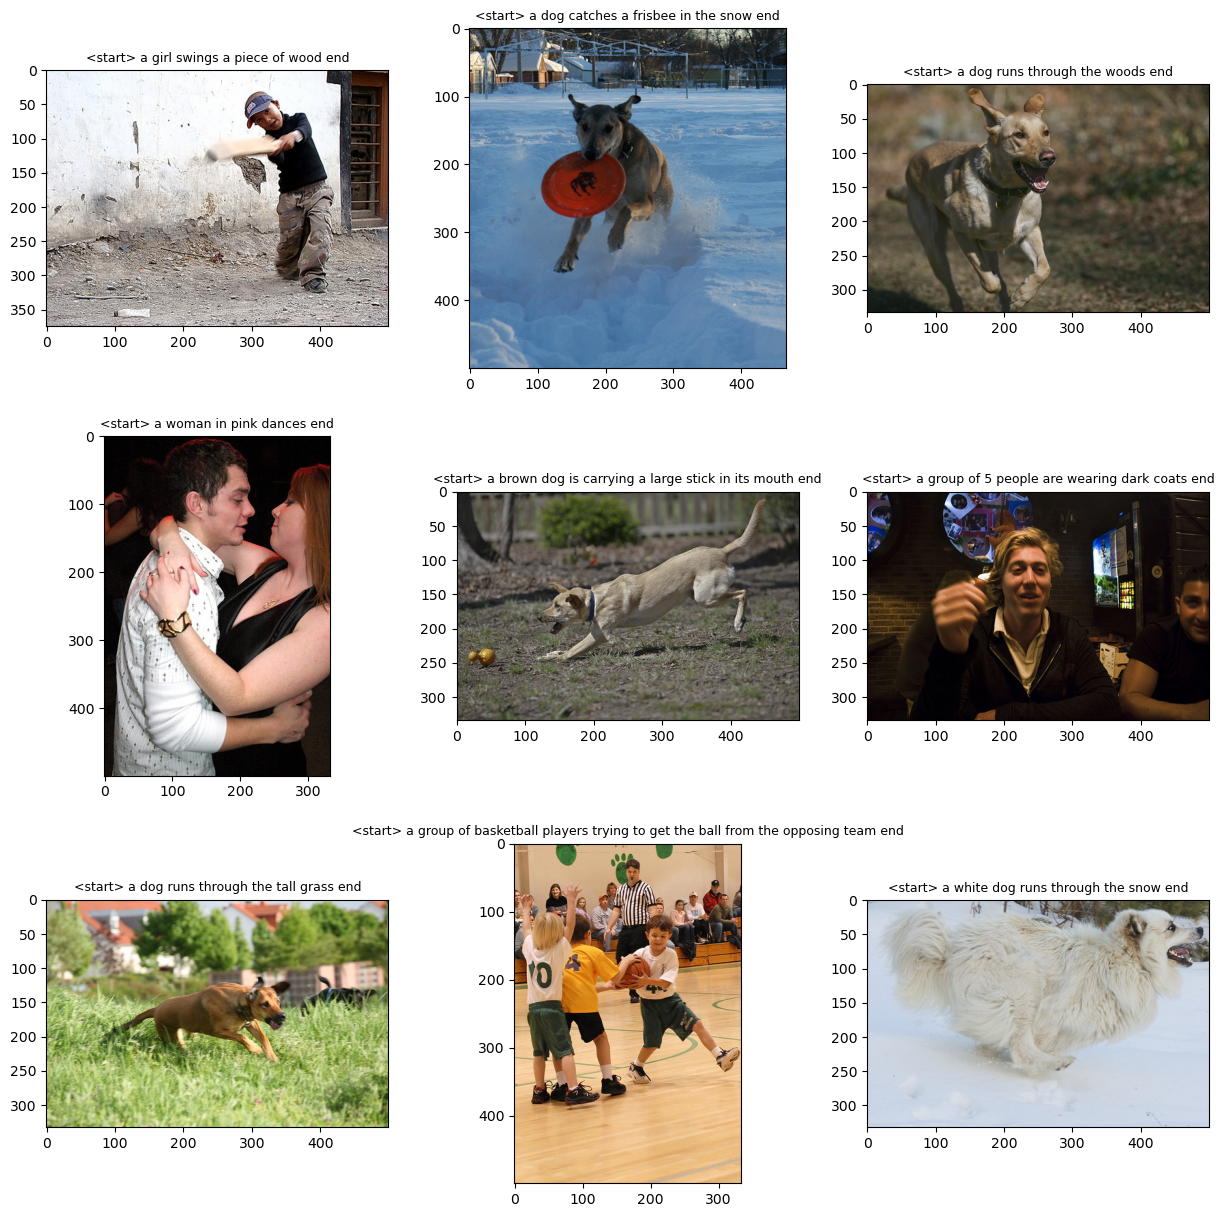

In [46]:
fig,axis=plt.subplots(3,3,figsize=(15,15))
flattens=axis.flatten()

for i,k in enumerate(flattens):
    randomt=random.randint(1,400)
    img=plt.imread(images[randomt])
    pre=beam_search_caption(images[randomt],3)
    k.imshow(img)
    k.set_title(pre, fontsize=9)


plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 873ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 814ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 830ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 820ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 811ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 822ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 828ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 802ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 799ms/step


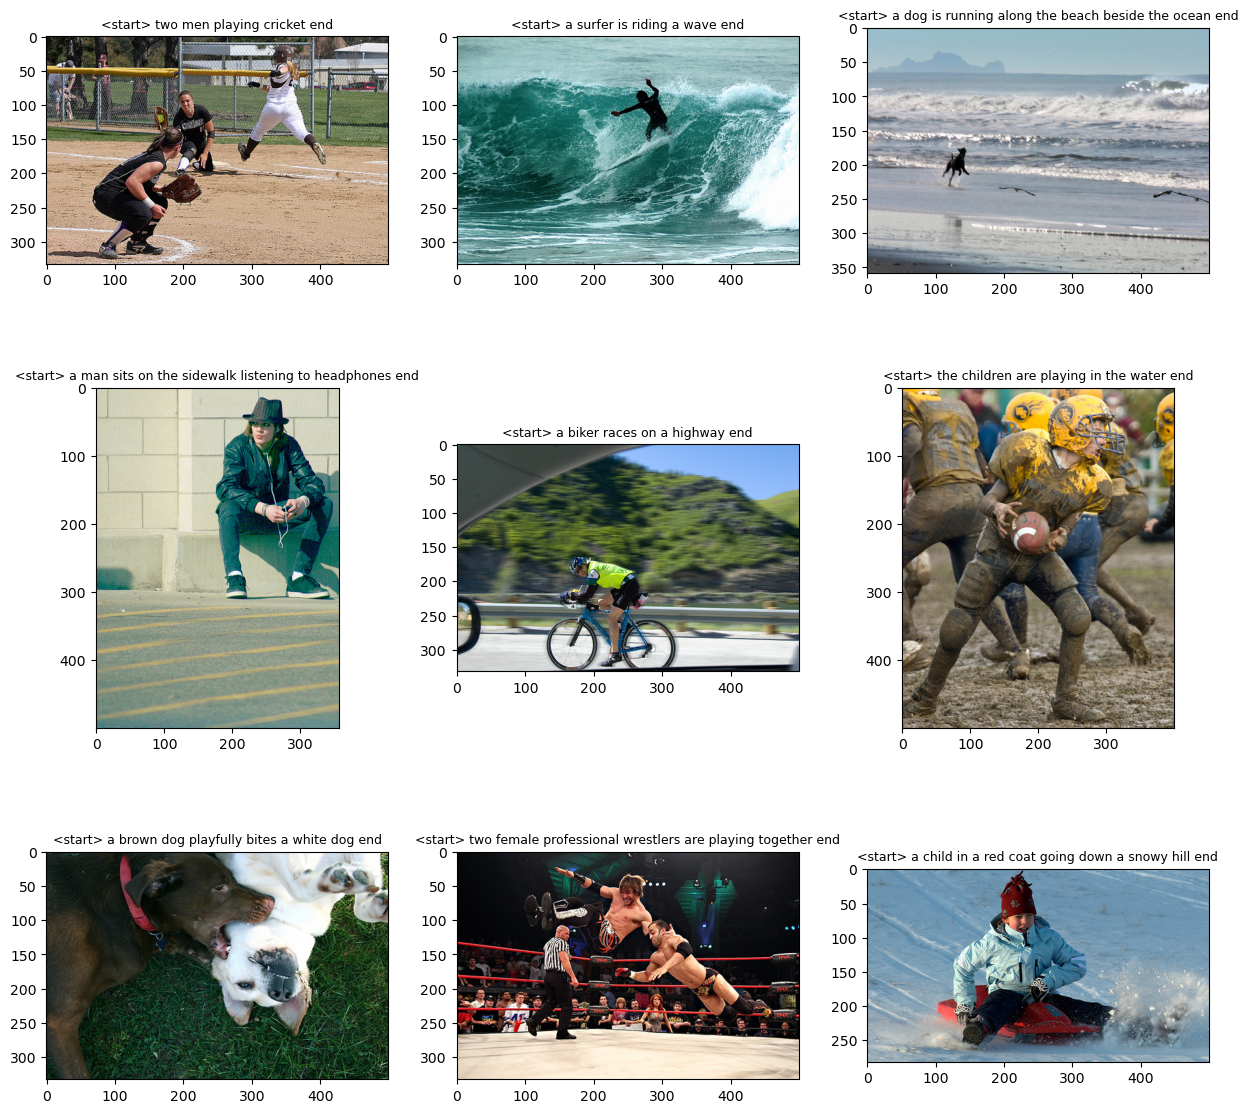

In [47]:
fig,axis=plt.subplots(3,3,figsize=(15,15))
flattens=axis.flatten()

for i,k in enumerate(flattens):
    randomt=random.randint(1,400)
    img=plt.imread(images[randomt])
    pre=beam_search_caption(images[randomt],3)
    k.imshow(img)
    k.set_title(pre, fontsize=9)


plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 961ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 805ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 803ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 792ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 808ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 827ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 808ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 895ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 801ms/step


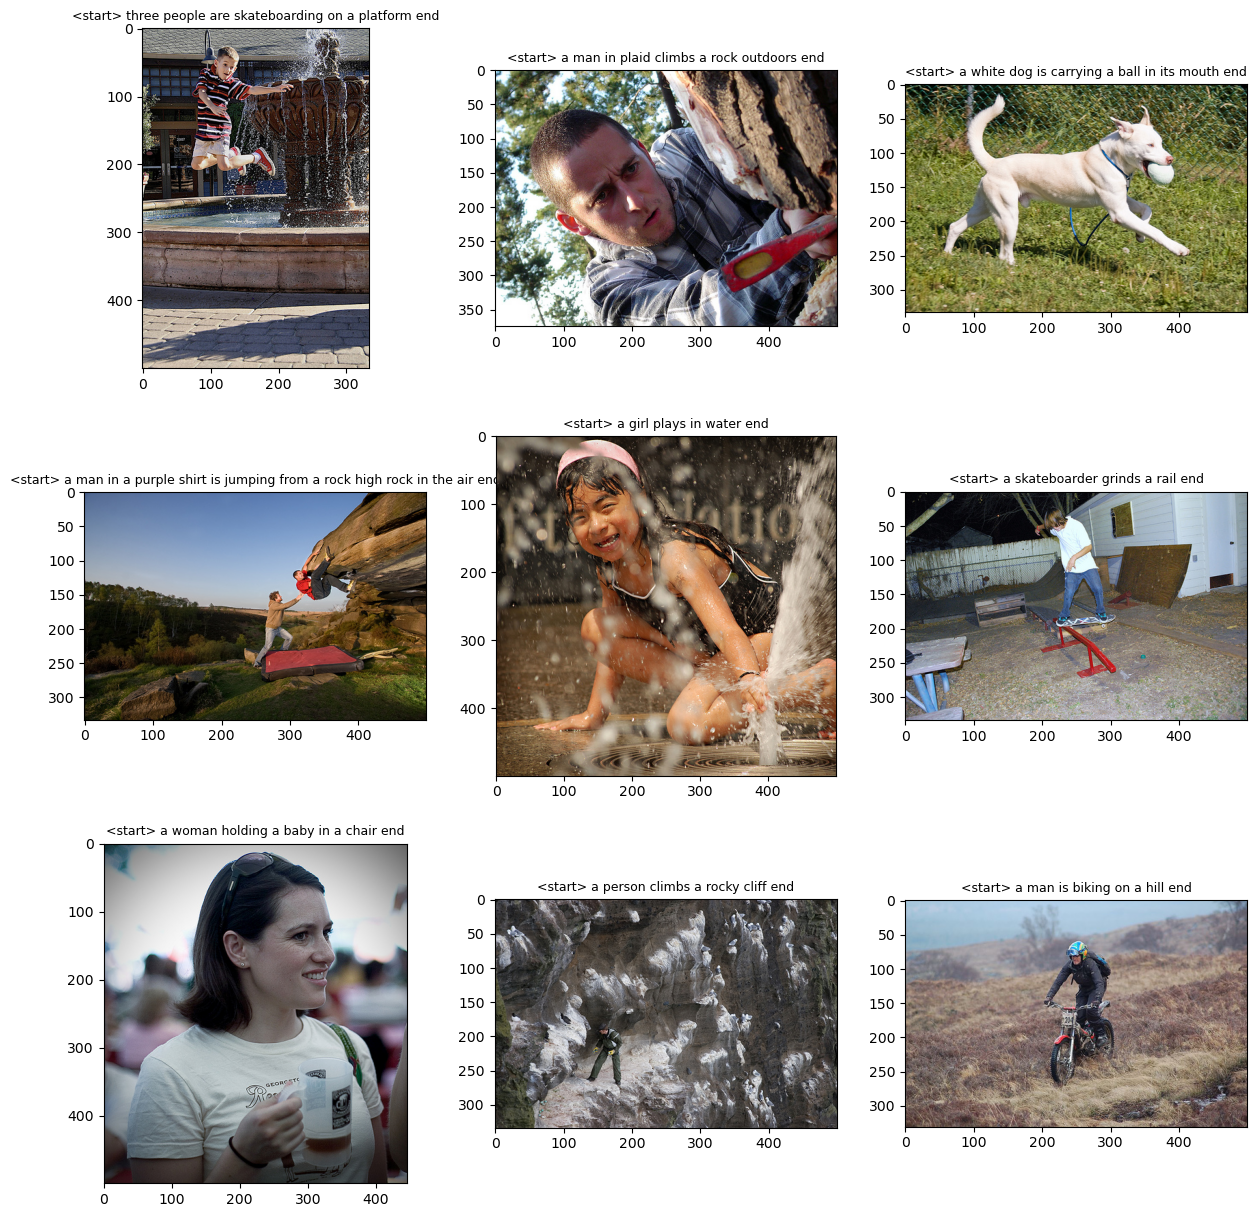

In [48]:
fig,axis=plt.subplots(3,3,figsize=(15,15))
flattens=axis.flatten()

for i,k in enumerate(flattens):
    randomt=random.randint(1,400)
    img=plt.imread(images[randomt])
    pre=beam_search_caption(images[randomt],3)
    k.imshow(img)
    k.set_title(pre, fontsize=9)


plt.show()

In [ ]:
# def tokenizer(text):
#     token=Tokenizer(num_words=20000,oov_token='unkw')
#     token_li=[]
#     for key,_ in text.items():

#         lines=[i for i in text[key] ]
#         token_li.extend(lines)
#     token.fit_on_texts(token_li)
#     return token

# len(tokenizer(captions_img).index_word)
        

In [ ]:
def generation_dataset(captions,photo,token):
    x1_t,x2_t,y_t=[],[],[]
    n=0
    while True:
        for i,k in captions.items():
            if i is not in photo:
                continue
        for des in k:
            seq=token.texts_to_sequences([des],maxlen=max_len,padding='post')[0]
            for i in range(len(1,seq)):
                in_seq=seq[:i]
                out_seq=seq[i]
                
                
                
            
        
        
    